<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/compvision_fixes/projects/ComputerVision/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning 

**By Neuromatch Academy**

__Content creators:__ [Jama Hussein Mohamud](https://engmubarak48.github.io/jmohamud/index.html) & [Alex Hernandez-Garcia](https://alexhernandezgarcia.github.io/)

__Production editors:__ Saeed Salehi, Spiros Chavlis



**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

One desired capability for machines is the ability to transfer the knowledge (features) learned on one domain to another This can potentially save compute time, enable training when data is scarce, and even improve performance. Unfortunately, there is no single recipe for transfer learning and instead multiple options are possible and much remains to be well understood. In this project, you will explore how transfer learning works in different scenarios. 

---
# Setup

In [1]:
# imports
import os
import gc
import csv
import glob
import torch
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [2]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

### Random seeds

If you want to obtain reproducible results, it is a good practice to set seeds for the random number generators of the various libraries

In [4]:
set_seed(seed=2021)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


### Training hyperparameters

Here we set some general training hyperparameters such as the learning rate, batch size, etc. as well as other training options such as including data augmentation (`torchvision_transforms`).

In [5]:
# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 128
max_epochs = 15  # Please change this to 200
max_epochs_target = 10
base_learning_rate = 0.1
torchvision_transforms = True  # True/False if you want use torchvision augmentations

---
# Data

## Source dataset

We will train the source model using CIFAR-100 data set from PyTorch, but with small tweaks we can get any other data we are interested in.

Note that the data set is normalised by substracted the mean and dividing by the standard deviation (pre-computed) of the training set. Also, if `torchvision_transforms` is `True`, data augmentation will be applied during training.

In [6]:
# @markdown Download and prepare Data
print('==> Preparing data..')
def percentageSplit(full_dataset, percent = 0.0):
  set1_size = int(percent * len(full_dataset))
  set2_size = len(full_dataset) - set1_size
  final_dataset, _ = torch.utils.data.random_split(full_dataset, [set1_size, set2_size])
  return final_dataset


# CIFAR100 normalizing
mean = [0.5071, 0.4866, 0.4409]
std = [0.2673, 0.2564, 0.2762]

# CIFAR10 normalizing
# mean = (0.4914, 0.4822, 0.4465)
# std = (0.2023, 0.1994, 0.2010)

# torchvision transforms
transform_train = transforms.Compose([])
if torchvision_transforms:
  transform_train.transforms.append(transforms.RandomCrop(32, padding=4))
  transform_train.transforms.append(transforms.RandomHorizontalFlip())

transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR100(
  root='./CIFAR100', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(
  root='./CIFAR100', train=False, download=True, transform=transform_test)

==> Preparing data..



Extracting ./CIFAR100/cifar-100-python.tar.gz to ./CIFAR100
Files already downloaded and verified


### CIFAR-100

CIFAR-100 is a data set of 50,000 colour (RGB) training images and 10,000 test images, of size 32 x 32 pixels. Each image is labelled as 1 of 100 possible classes. 

The data set is stored as a custom `torchvision.datasets.cifar.CIFAR` object. You can check some of its properties with the following code:

In [7]:
print(f"Object type: {type(trainset)}")
print(f"Training data shape: {trainset.data.shape}")
print(f"Test data shape: {testset.data.shape}")
print(f"Number of classes: {np.unique(trainset.targets).shape[0]}")

Object type: <class 'torchvision.datasets.cifar.CIFAR100'>
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Number of classes: 100


## Data loaders

A dataloader is an optimized data iterator that provides functionality for efficient shuffling, transformation and batching of the data.

In [8]:
##@title Dataloader 
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 2


## Architecture: ResNet

ResNet is a family of network architectures whose main property is that the network is organised as a stack of _residual blocks_. Residual blocks consist of a stack of layers whose output is added the input, making a _shortcut connection_.

See the [original paper](https://arxiv.org/abs/1512.03385) for more details.

ResNet is just a popular choice out of many others, but data augmentation works well in general. We just picked ResNet for illustration purposes.

In [9]:
# @title ResNet model in PyTorch

class BasicBlock(nn.Module):
  """ResNet in PyTorch.
      Reference:
      [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
        Deep Residual Learning for Image Recognition. arXiv:1512.03385
  """

  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=100):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
  return ResNet(Bottleneck, [3, 4, 6, 3])

#### Test on random data

In [10]:
# Load the Model
net = ResNet18()
print('-----> verify if model is run on random data')
y = net(Variable(torch.randn(1,3,32,32)))
print('model loaded')

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + net.__class__.__name__ + '_pretrain' + '.csv'

if use_cuda:
  net.cuda()
  net = torch.nn.DataParallel(net)
  print('Using', torch.cuda.device_count(), 'GPUs.')
  cudnn.benchmark = True
  print('Using CUDA..')

-----> verify if model is run on random data
model loaded
Using 1 GPUs.
Using CUDA..


## Set up training

### Set loss function and optimizer

We use the cross entropy loss, commonly used for classification, and stochastic gradient descent (SGD) as optimizer, with momentum and weight decay.

In [11]:
# Optimizer and criterion 

criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(net.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

### Train and test loops

In [12]:
# Training & Test functions

def train(net, epoch, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
      
    if batch_idx % 500 == 0:
      print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, outModelName, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    checkpoint(net, acc, epoch, outModelName)
  return (test_loss/batch_idx, 100.*correct/total)

### Auxiliary functions

* `checkpoint()`: Store checkpoints of the model
* `adjust_learning_rate()`: Decreases the learning rate (learning rate decay) at certain epochs of training.

In [13]:
# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

### Train the model

This is the loop where the model is trained for `max_epochs` epochs.

In [14]:
# Start training
outModelName = 'pretrain'
if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
      logwriter = csv.writer(logfile, delimiter=',')
      logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

for epoch in range(start_epoch, max_epochs):
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(net, epoch, use_cuda=use_cuda)
  test_loss, test_acc = test(net, epoch, outModelName, use_cuda=use_cuda)
  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
  print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
0 391 Loss: 4.748 | Acc: 0.781% (1/128)
0 79 Loss: 3.545 | Acc: 12.500% (16/128)
Saving..
Epoch: 0 | train acc: 8.527999877929688 | test acc: 13.369999885559082

Epoch: 1
0 391 Loss: 3.597 | Acc: 16.406% (21/128)
0 79 Loss: 3.157 | Acc: 23.438% (30/128)
Saving..
Epoch: 1 | train acc: 18.392000198364258 | test acc: 21.829999923706055

Epoch: 2
0 391 Loss: 2.932 | Acc: 26.562% (34/128)
0 79 Loss: 2.450 | Acc: 39.844% (51/128)
Saving..
Epoch: 2 | train acc: 27.016000747680664 | test acc: 31.079999923706055

Epoch: 3
0 391 Loss: 2.649 | Acc: 35.938% (46/128)
0 79 Loss: 2.134 | Acc: 39.844% (51/128)
Saving..
Epoch: 3 | train acc: 35.84000015258789 | test acc: 35.70000076293945

Epoch: 4
0 391 Loss: 2.153 | Acc: 41.406% (53/128)
0 79 Loss: 1.911 | Acc: 49.219% (63/128)
Saving..
Epoch: 4 | train acc: 42.827999114990234 | test acc: 43.619998931884766

Epoch: 5
0 391 Loss: 1.878 | Acc: 50.000% (64/128)
0 79 Loss: 2.149 | Acc: 43.750% (56/128)
Saving..
Epoch: 5 | train acc: 48.87200164

## Transfer learning
### Re-use the trained model to improve training on a different data set

### Delete variables from the previous model

In [15]:
# delete the backbone network
delete = True
if delete:
  del net
  del trainset
  del testset
  del trainloader
  del testloader
  gc.collect()

#### Target dataset

We will now use CIFAR-10 as _target_ data set. Again, with small tweaks we can get any other data we are interested in.

CIFAR-10 is very similar to CIFAR-100, but it contains only 10 classes instead of 100.

In [16]:
# Target domain Data
print('==> Preparing target domain data..')

# CIFAR10 normalizing
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
num_classes = 10
lr = 0.0001

# torchvision transforms
transform_train = transforms.Compose([])
if torchvision_transforms:
    transform_train.transforms.append(transforms.RandomCrop(32, padding=4))
    transform_train.transforms.append(transforms.RandomHorizontalFlip())

transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=False, download=True, transform=transform_test)

==> Preparing target domain data..



Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


#### Select a subset of the data

To simulate a lower data regime, where transfer learning can be useful.

Choose percentage from the trainset. Set `percent = 1.0` to use the whole train data

In [17]:
percent = 0.6

trainset = percentageSplit(trainset, percent = percent)
print('size of the new trainset: ', len(trainset))

size of the new trainset:  30000


#### Dataloaders

As before

In [18]:
# Dataloader 
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 2


### Load pre-trained model

Load the checkpoint of the model previously trained on CIFAR-100

In [19]:
model = ResNet18()

checkpointPath = '/content/checkpoint/pretrain.t7'

print(' ===> loading pretrained model from: ', checkpointPath)
if os.path.isfile(checkpointPath):
  state_dict = torch.load(checkpointPath)
  best_acc = state_dict['acc']
  print('Best Accuracy:', best_acc)
  if "state_dict" in state_dict:
      state_dict = state_dict["state_dict"]
  # remove prefixe "module."
  state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
  for k, v in model.state_dict().items():
    if k not in list(state_dict):
      print('key "{}" could not be found in provided state dict'.format(k))
    elif state_dict[k].shape != v.shape:
      print('key "{}" is of different shape in model and provided state dict'.format(k))
      state_dict[k] = v
  msg = model.load_state_dict(state_dict, strict=False)
  print("Load pretrained model with msg: {}".format(msg))
else:
  raise Exception('No pretrained weights found')

 ===> loading pretrained model from:  /content/checkpoint/pretrain.t7
Best Accuracy: tensor(62.9100)
Load pretrained model with msg: <All keys matched successfully>


### Freeze model parameters

In transfer learning, we usually do not re-train all the weights of the model, but only a subset of them, for instance the last layer. Here we first _freeze_ all the parameters of the model, and we will _unfreeze_ one layer below.

In [20]:
# Freeze the model parameters, you can also freeze some layers only

for param in model.parameters():
  param.requires_grad = False

### Loss function, optimizer and _unfreeze_ last layer

In [21]:
num_ftrs = model.linear.in_features
model.linear = nn.Linear(num_ftrs, num_classes)

model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(
    model.linear.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4,
)

#### Check number of parameters

We can calculate the number of total parameters and the number of trainable parameters, that is those that will be updated during training. Since we have freezed most of the parameters, the number of training parameters should be much smaller.

In [22]:
total_params = sum(p.numel() for p in model.parameters())
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total Parameters:', total_params, 'Trainable parameters: ', trainable_total_params)

Total Parameters: 11173962 Trainable parameters:  5130


### Train the target model

In [23]:
outModelName = 'finetuned'
logname = result_folder + model.__class__.__name__ + f'_{outModelName}.csv'

if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

for epoch in range(start_epoch, max_epochs_target):
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(model, epoch, use_cuda=use_cuda)
  test_loss, test_acc = test(model, epoch, outModelName, use_cuda=use_cuda)
  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
  print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
0 235 Loss: 2.302 | Acc: 16.406% (21/128)
0 79 Loss: 0.630 | Acc: 79.688% (102/128)
Saving..
Epoch: 0 | train acc: 71.086669921875 | test acc: 75.08999633789062

Epoch: 1
0 235 Loss: 0.757 | Acc: 72.656% (93/128)
0 79 Loss: 0.619 | Acc: 79.688% (102/128)
Saving..
Epoch: 1 | train acc: 75.86000061035156 | test acc: 76.54000091552734

Epoch: 2
0 235 Loss: 0.666 | Acc: 75.781% (97/128)
0 79 Loss: 0.640 | Acc: 78.125% (100/128)
Saving..
Epoch: 2 | train acc: 77.04000091552734 | test acc: 76.55000305175781

Epoch: 3
0 235 Loss: 0.579 | Acc: 81.250% (104/128)
0 79 Loss: 0.577 | Acc: 79.688% (102/128)
Saving..
Epoch: 3 | train acc: 77.56999969482422 | test acc: 77.2300033569336

Epoch: 4
0 235 Loss: 0.661 | Acc: 78.125% (100/128)
0 79 Loss: 0.613 | Acc: 76.562% (98/128)
Saving..
Epoch: 4 | train acc: 77.6866683959961 | test acc: 77.44999694824219

Epoch: 5
0 235 Loss: 0.627 | Acc: 80.469% (103/128)
0 79 Loss: 0.626 | Acc: 80.469% (103/128)
Epoch: 5 | train acc: 78.163330078125 | tes

## Plot results

In [24]:
# title plot results
results = pd.read_csv(f'/content/results/ResNet_{outModelName}.csv', sep =',')
results.head()

,epoch,train loss,train acc,test loss,test acc
0,0,0.819690,71.086670,0.713260,75.089996
1,1,0.680940,75.860001,0.674431,76.540001
2,2,0.650245,77.040001,0.675883,76.550003
3,3,0.638555,77.570000,0.652776,77.230003
4,4,0.630500,77.686668,0.666428,77.449997


In [25]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values

print(f'Average Accuracy over {max_epochs_target} epochs:', sum(test_accuracy)//len(test_accuracy))
print(f'best accuraccy over {max_epochs_target} epochs:', max(test_accuracy))

Average Accuracy over 10 epochs: 77.0
best accuraccy over 10 epochs: 78.20999908447266


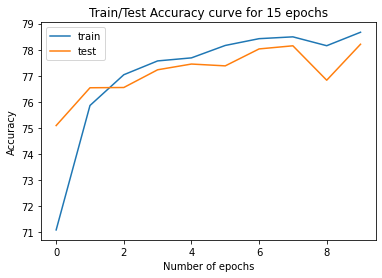

In [26]:
figureName = 'figure' # change figure name

plt.plot(results['epoch'].values, train_accuracy, label='train')
plt.plot(results['epoch'].values, test_accuracy, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title(f'Train/Test Accuracy curve for {max_epochs} epochs')
plt.savefig(f'/content/results/{figureName}.png')
plt.legend()
plt.show()